In [1]:
from nbed.driver import NbedDriver
from nbed.ham_converter import HamiltonianConverter
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule

/Users/lex/anaconda3/envs/embed/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
localization = 'spade'
n_active_atoms = 2 # <--------

In [3]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [4]:
sorted(os.listdir(structure_dir))

['H4_beta_85_bottom_bottom_top_top_order.xyz',
 'H4_beta_85_bottom_top_bottom_top_order.xyz',
 'H4_beta_86_bottom_bottom_top_top_order.xyz',
 'H4_beta_86_bottom_top_bottom_top_order.xyz',
 'H4_beta_87_bottom_bottom_top_top_order.xyz',
 'H4_beta_87_bottom_top_bottom_top_order.xyz',
 'H4_beta_88_bottom_bottom_top_top_order.xyz',
 'H4_beta_88_bottom_top_bottom_top_order.xyz',
 'H4_beta_89_bottom_bottom_top_top_order.xyz',
 'H4_beta_89_bottom_top_bottom_top_order.xyz',
 'H4_beta_90_bottom_bottom_top_top_order.xyz',
 'H4_beta_90_bottom_top_bottom_top_order.xyz',
 'H4_beta_91_bottom_bottom_top_top_order.xyz',
 'H4_beta_91_bottom_top_bottom_top_order.xyz',
 'H4_beta_92_bottom_bottom_top_top_order.xyz',
 'H4_beta_92_bottom_top_bottom_top_order.xyz',
 'H4_beta_93_bottom_bottom_top_top_order.xyz',
 'H4_beta_93_bottom_top_bottom_top_order.xyz',
 'H4_beta_94_bottom_bottom_top_top_order.xyz',
 'H4_beta_94_bottom_top_bottom_top_order.xyz',
 'H4_beta_95_bottom_bottom_top_top_order.xyz',
 'H4_beta_95_

In [5]:
ending = 'bottom_top_bottom_top_order.xyz'

bottom_top_bottom_top_file_paths = []
for xyz_filename in sorted(os.listdir(structure_dir)):
    if  xyz_filename.endswith(ending):
        bottom_top_bottom_top_file_paths.append(os.path.join(structure_dir, xyz_filename))

In [6]:
file_index = 5
with open(bottom_top_bottom_top_file_paths[file_index], 'r') as infile:
    xyz = infile.read()

print('molecule: ', bottom_top_bottom_top_file_paths[file_index][-42:])
mol_viewer = Draw_molecule(xyz)
mol_viewer.show()

molecule:  H4_beta_90_bottom_top_bottom_top_order.xyz


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

H4_beta_85_bottom_top_bottom_top_order.xyz
H4_beta_90_bottom_top_bottom_top_order.xyz
H4_beta_95_bottom_top_bottom_top_order.xyz


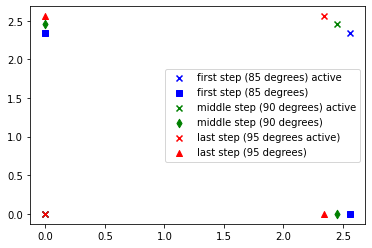

In [7]:
# active part is bottom left and top right 

def coords_as_numpy_array(xyz_str):
    n_atoms = int(xyz_str[:xyz_str.find('\n')])
    coord_array = np.zeros((n_atoms, 3))
    
    for ind, xyz_line in enumerate(xyz_str[4:-1].split('\n')):
        xyz_array = np.array([float(xyz) for xyz in xyz_line.split('\t')[1:]])
        coord_array[ind, :] = xyz_array
        
    return coord_array

with open(bottom_top_bottom_top_file_paths[0], 'r') as infile:
    xyz1 = infile.read()
with open(bottom_top_bottom_top_file_paths[int(len(bottom_top_bottom_top_file_paths)/2)], 'r') as infile:
    xyz2 = infile.read()
with open(bottom_top_bottom_top_file_paths[-1], 'r') as infile:
    xyz3 = infile.read()

print(bottom_top_bottom_top_file_paths[0][-42:])
print(bottom_top_bottom_top_file_paths[int(len(bottom_top_bottom_top_file_paths)/2)][-42:])
print(bottom_top_bottom_top_file_paths[-1][-42:])

numpy_xyz1 = coords_as_numpy_array(xyz1)
numpy_xyz2 = coords_as_numpy_array(xyz2)
numpy_xyz3 = coords_as_numpy_array(xyz3)

plt.scatter(numpy_xyz1[:n_active_atoms,0], numpy_xyz1[:n_active_atoms,1], label='first step (85 degrees) active', marker='x', color='b')
plt.scatter(numpy_xyz1[n_active_atoms:,0], numpy_xyz1[n_active_atoms:,1], label='first step (85 degrees)', marker='s', color='b')

plt.scatter(numpy_xyz2[:n_active_atoms,0], numpy_xyz2[:n_active_atoms,1], label='middle step (90 degrees) active', marker='x', color='g')
plt.scatter(numpy_xyz2[n_active_atoms:,0], numpy_xyz2[n_active_atoms:,1], label='middle step (90 degrees)', marker='d', color='g')

plt.scatter(numpy_xyz3[:n_active_atoms,0], numpy_xyz3[:n_active_atoms,1], label='last step (95 degrees active)', marker='x', color='r')
plt.scatter(numpy_xyz3[n_active_atoms:,0], numpy_xyz3[n_active_atoms:,1], label='last step (95 degrees)', marker='^', color='r')

plt.legend()
plt.show()

In [8]:
basis = 'STO-3G'
xc_functional = 'B3LYP'
projector = 'both'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = True
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'
occupied_threshold = 0.95
virtual_threshold = 0.95

In [9]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for geometry_path in tqdm(bottom_top_bottom_top_file_paths):
    try:
        driver = NbedDriver(
                geometry=geometry_path,
                n_active_atoms=n_active_atoms,
                basis=basis,
                xc_functional=xc_functional,
                projector=projector,
                localization=localization,
                convergence=convergence,
                charge=charge,
                mu_level_shift=mu_level_shift,
                run_ccsd_emb=run_ccsd_emb,
                run_fci_emb=run_fci_emb,
                max_ram_memory=max_ram_memory,
                pyscf_print_level=pyscf_print_level,
                unit=unit,
                occupied_threshold=occupied_threshold,
                virtual_threshold=virtual_threshold)
    except:
        print('error for:')
        print(geometry_path)
        print()
        continue

    
    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_H = driver.full_system_hamiltonian
    global_H_sparse = get_sparse_operator(global_H)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] + driver._global_hf.energy_nuc()
    global_H_diag_list.append(E_fci)
    
    global_qubit_Ham = getattr( HamiltonianConverter(global_H, transform='jordan_wigner'), 'openfermion')
    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_H_emb = driver._huzinaga['hamiltonian']
    huz_classical = driver._huzinaga['classical_energy']
    huz_H_sparse = get_sparse_operator(huz_H_emb)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)
    
    huz_qubit_Ham = getattr( HamiltonianConverter(huz_H_emb, transform='jordan_wigner'), 'openfermion')
    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
    mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_H_emb = driver._mu['hamiltonian']
    mu_classical = driver._mu['classical_energy']
    mu_H_sparse = get_sparse_operator(mu_H_emb)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_qubit_Ham = getattr( HamiltonianConverter(mu_H_emb, transform='jordan_wigner'), 'openfermion')
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
import pandas as pd
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits
0,-1.713780,-1.875969,-1.752658,-1.752658,97,62,62,8,6,6
1,-1.709245,-1.875394,-1.686694,-1.686694,97,62,62,8,6,6
2,-1.704842,-1.874932,-1.720031,-1.720031,97,62,62,8,6,6
3,-1.700565,-1.874591,-1.762622,-1.812985,97,62,62,8,6,6
4,-1.696407,-1.874382,-1.633914,-1.633914,97,62,62,8,6,6
5,-1.163195,-1.874311,-209.593087,-1.145597,105,98,46,8,6,6
6,-1.696407,-1.874382,-1.644182,-1.644182,97,62,62,8,6,6
7,-1.700565,-1.874591,-1.760289,-1.760289,97,62,62,8,6,6
8,-1.704842,-1.874932,-1.646151,-1.646151,97,62,62,8,6,6
9,-1.709245,-1.875394,-1.748056,-1.748056,97,62,62,8,6,6


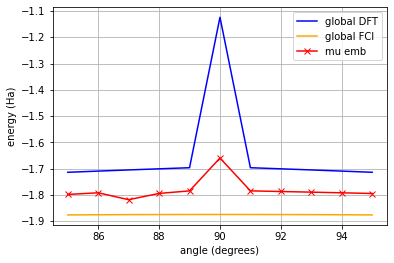

In [19]:
%matplotlib inline

angles = list(range(85,96))
# angles = list(range(85,87))

plt.plot(angles, global_dft_list, label='global DFT', color='b')
plt.plot(angles, global_fci_list, label='global FCI', color='orange')
plt.plot(angles, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

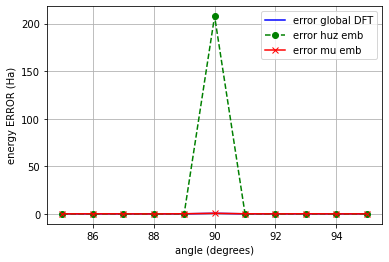

In [12]:
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(global_dft_list)), label='error global DFT', color='b')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(huz_H_diag_list)) , label='error huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(mu_H_diag_list)) , label='error mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy ERROR (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

In [13]:
ending = 'bottom_bottom_top_top_order.xyz'

bottom_bottom_top_top_file_paths = []
for xyz_filename in sorted(os.listdir(structure_dir)):
    if  xyz_filename.endswith(ending):
        bottom_bottom_top_top_file_paths.append(os.path.join(structure_dir, xyz_filename))

H4_beta_85_bottom_bottom_top_top_order.xyz
H4_beta_90_bottom_bottom_top_top_order.xyz
H4_beta_95_bottom_bottom_top_top_order.xyz


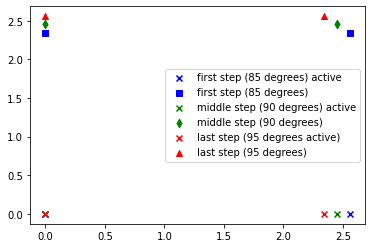

In [14]:
# active part is bottom left and right!

with open(bottom_bottom_top_top_file_paths[0], 'r') as infile:
    xyz1 = infile.read()
with open(bottom_bottom_top_top_file_paths[int(len(bottom_bottom_top_top_file_paths)/2)], 'r') as infile:
    xyz2 = infile.read()
with open(bottom_bottom_top_top_file_paths[-1], 'r') as infile:
    xyz3 = infile.read()

numpy_xyz1_new = coords_as_numpy_array(xyz1)
numpy_xyz2_new = coords_as_numpy_array(xyz2)
numpy_xyz3_new = coords_as_numpy_array(xyz3)

print(bottom_bottom_top_top_file_paths[0][-42:])
print(bottom_bottom_top_top_file_paths[int(len(bottom_top_bottom_top_file_paths)/2)][-42:])
print(bottom_bottom_top_top_file_paths[-1][-42:])



plt.scatter(numpy_xyz1_new[:n_active_atoms,0], numpy_xyz1_new[:n_active_atoms,1], label='first step (85 degrees) active', marker='x', color='b')
plt.scatter(numpy_xyz1_new[n_active_atoms:,0], numpy_xyz1_new[n_active_atoms:,1], label='first step (85 degrees)', marker='s', color='b')

plt.scatter(numpy_xyz2_new[:n_active_atoms,0], numpy_xyz2_new[:n_active_atoms,1], label='middle step (90 degrees) active', marker='x', color='g')
plt.scatter(numpy_xyz2_new[n_active_atoms:,0], numpy_xyz2_new[n_active_atoms:,1], label='middle step (90 degrees)', marker='d', color='g')

plt.scatter(numpy_xyz3_new[:n_active_atoms,0], numpy_xyz3_new[:n_active_atoms,1], label='last step (95 degrees active)', marker='x', color='r')
plt.scatter(numpy_xyz3_new[n_active_atoms:,0], numpy_xyz3_new[n_active_atoms:,1], label='last step (95 degrees)', marker='^', color='r')

plt.legend()
plt.show()

In [15]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for geometry_path in tqdm(bottom_bottom_top_top_file_paths):
    try:
        driver = NbedDriver(
                geometry=geometry_path,
                n_active_atoms=n_active_atoms,
                basis=basis,
                xc_functional=xc_functional,
                projector=projector,
                localization=localization,
                convergence=convergence,
                charge=charge,
                mu_level_shift=mu_level_shift,
                run_ccsd_emb=run_ccsd_emb,
                run_fci_emb=run_fci_emb,
                max_ram_memory=max_ram_memory,
                pyscf_print_level=pyscf_print_level,
                unit=unit,
                occupied_threshold=occupied_threshold,
                virtual_threshold=virtual_threshold)
    except:
        print('error for:')
        print(geometry_path)
        print()
        continue

    
    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_H = driver.full_system_hamiltonian
    global_H_sparse = get_sparse_operator(global_H)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] + driver._global_hf.energy_nuc()
    global_H_diag_list.append(E_fci)
    
    global_qubit_Ham = getattr( HamiltonianConverter(global_H, transform='jordan_wigner'), 'openfermion')
    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_H_emb = driver._huzinaga['hamiltonian']
    huz_classical = driver._huzinaga['classical_energy']
    huz_H_sparse = get_sparse_operator(huz_H_emb)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)
    
    huz_qubit_Ham = getattr( HamiltonianConverter(huz_H_emb, transform='jordan_wigner'), 'openfermion')
    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
    mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_H_emb = driver._mu['hamiltonian']
    mu_classical = driver._mu['classical_energy']
    mu_H_sparse = get_sparse_operator(mu_H_emb)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_qubit_Ham = getattr( HamiltonianConverter(mu_H_emb, transform='jordan_wigner'), 'openfermion')
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    'N active AOs ': N_active_AOs,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active AOs
0,-1.713780,-1.875969,-1.767209,-1.798050,97,62,62,8,6,6,1
1,-1.709245,-1.875394,-1.753955,-1.791809,97,62,62,8,6,6,1
2,-1.704842,-1.874932,-1.768241,-1.818059,97,62,62,8,6,6,1
3,-1.700565,-1.874591,-1.751917,-1.794189,97,62,62,8,6,6,1
4,-1.696407,-1.874382,-1.719949,-1.784502,97,62,62,8,6,6,1
5,-1.123898,-1.874311,-2.460943,-1.659547,177,62,62,8,6,6,1
6,-1.696407,-1.874382,-1.729882,-1.784499,97,62,62,8,6,6,1
7,-1.700565,-1.874591,-1.740246,-1.786878,97,62,62,8,6,6,1
8,-1.704842,-1.874932,-1.747948,-1.789331,97,62,62,8,6,6,1
9,-1.709245,-1.875394,-1.753784,-1.791868,97,62,62,8,6,6,1


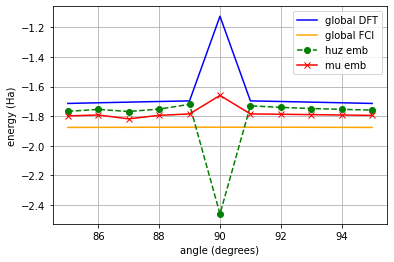

In [17]:
%matplotlib inline

angles = list(range(85,96))
# angles = list(range(85,87))

plt.plot(angles, global_dft_list, label='global DFT', color='b')
plt.plot(angles, global_fci_list, label='global FCI', color='orange')
plt.plot(angles, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

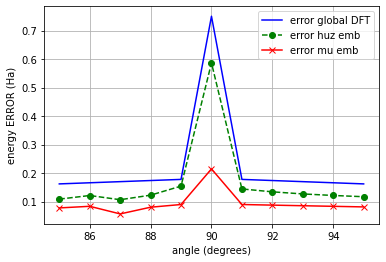

In [18]:
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(global_dft_list)), label='error global DFT', color='b')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(huz_H_diag_list)) , label='error huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(angles, np.abs(np.array(global_fci_list)-np.array(mu_H_diag_list)) , label='error mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('angle (degrees)')
plt.ylabel('energy ERROR (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()